# 8. 비지도 학습
## 8.4 생성적 적대 신경망

In [6]:
!pip3 install imageio

In [7]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import imageio
import numpy as np
from matplotlib import pyplot as plt

In [8]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [9]:
#cd/content/gdrive/My Drive/pytorch_dlbro

In [10]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5,0.5)])
trainset = FashionMNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 'T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data/FashionMNIST\raw


  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data/FashionMNIST\raw


  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data/FashionMNIST\raw


  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST\raw
Processing...
Done!


C:\Users\bitcamp\.conda\envs\yoloenv\lib\site-packages\torchvision\datasets\mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.linear = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2),
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2),
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )
 
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 1, 28, 28)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.linear = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear(x)
        return x

In [12]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

pretrained =  False
if pretrained == True:
    discriminator.load_state_dict(torch.load('./models/fmnist_disc.pth'))
    generator.load_state_dict(torch.load('./models/fmnist_gner.pth'))

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss()

def noise(n, n_features=128):
    data = torch.randn(n, n_features)
    return data.to(device)

def label_ones(size):
    data = torch.ones(size, 1)
    return data.to(device)

def label_zeros(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [13]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    d_loss = criterion(prediction_real, label_ones(n))

    prediction_fake = discriminator(fake_data)
    g_loss = criterion(prediction_fake, label_zeros(n))
    
    loss = d_loss + g_loss

    loss.backward()
    optimizer.step()
    
    return loss.item()

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    loss = criterion(prediction, label_ones(n))
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [14]:
test_noise = noise(64)
l = len(trainloader)

for epoch in range(151):
    g_loss = 0.0
    d_loss = 0.0

    for data in trainloader:
        imgs, _ = data
        n = len(imgs)
        z = noise(n)
        fake_data = generator(z).detach()
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(z)
        g_loss += train_generator(g_optim, fake_data)

    img = generator(test_noise).detach().cpu()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)

    if epoch % 10 == 0:
        print('Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r'.format(epoch, g_loss/l, d_loss/l))
       
torch.save(discriminator.state_dict(), './models/fmnist_disc.pth') 
torch.save(generator.state_dict(), './models/fmnist_gner.pth')    

Epoch 0: g_loss: 2.802 d_loss: 0.821
Epoch 10: g_loss: 1.921 d_loss: 0.806
Epoch 20: g_loss: 1.503 d_loss: 0.944
Epoch 30: g_loss: 1.368 d_loss: 0.989
Epoch 40: g_loss: 1.283 d_loss: 1.049
Epoch 50: g_loss: 1.244 d_loss: 1.055
Epoch 60: g_loss: 1.219 d_loss: 1.087
Epoch 70: g_loss: 1.171 d_loss: 1.112
Epoch 80: g_loss: 1.142 d_loss: 1.121
Epoch 90: g_loss: 1.076 d_loss: 1.165
Epoch 100: g_loss: 1.066 d_loss: 1.167
Epoch 110: g_loss: 1.039 d_loss: 1.188
Epoch 120: g_loss: 1.006 d_loss: 1.207
Epoch 130: g_loss: 1.031 d_loss: 1.197
Epoch 140: g_loss: 1.024 d_loss: 1.203
Epoch 150: g_loss: 0.995 d_loss: 1.210


In [15]:
to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('fashion_items_gan.gif', imgs)

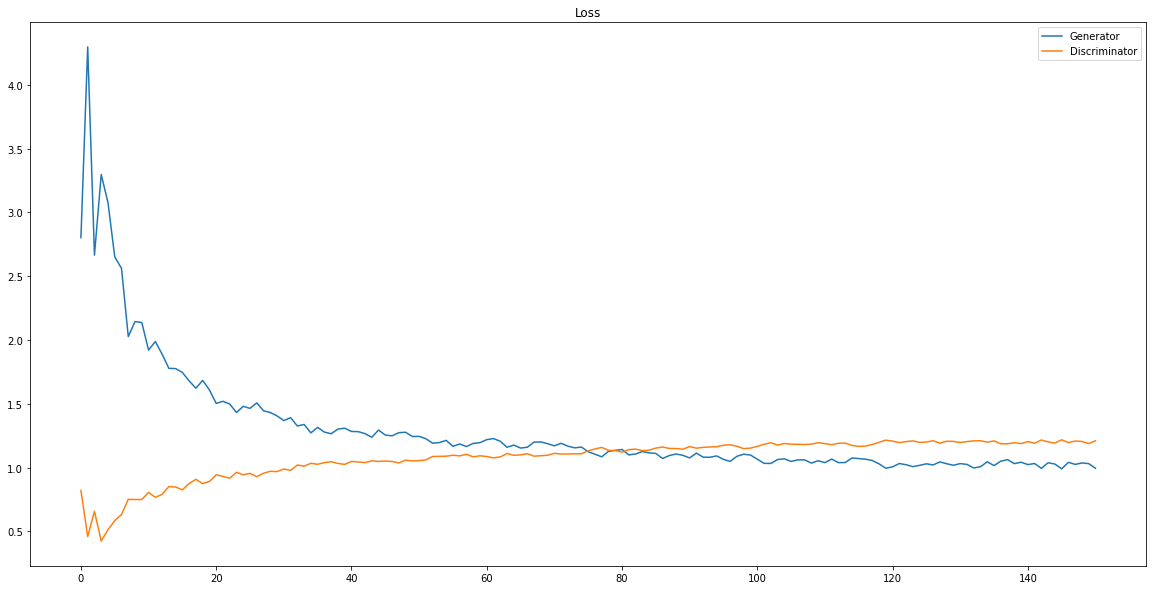

In [16]:
plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator','Discriminator'])
plt.title('Loss')
plt.savefig('gan_loss.png')

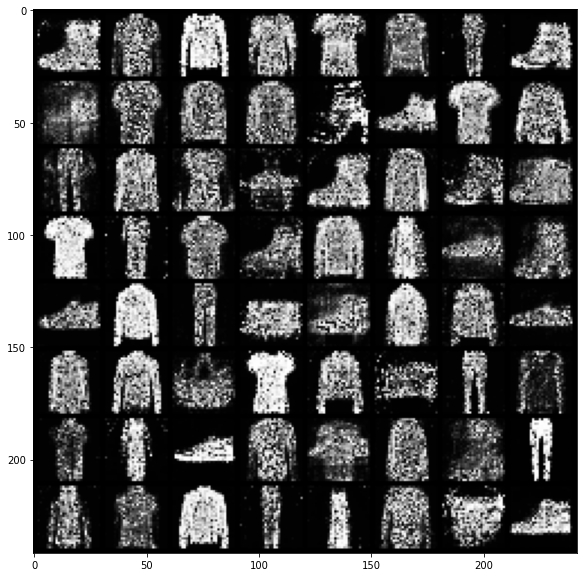

In [17]:
test_noise = noise(64)
to_image = transforms.ToPILImage()
img = generator(test_noise).cpu().detach()
img = to_image(make_grid(img))
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()